In [1]:
from __future__ import print_function, division
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier

from data_preprocess import get_data_loader, CustomDataset
%load_ext autoreload
%autoreload 2

In [2]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

data_dir = "/scratch/jt3149/"#where the data is
snapshots_dir = '/scratch/jt3149/snapshots03/' # where the snapshots are 

train_loader, val_loader, test_loader = get_data_loader(data_dir, batch_size=64, trans=preprocess, val_size = 0.2)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
# read the pretrained densenet
densenet_based = torchvision.models.densenet201(weights='DenseNet201_Weights.DEFAULT')

## freeze the layers
for param in densenet_based.parameters():
    param.requires_grad = False
    
# print(densenet_based)
# Modify the last layer
number_features = densenet_based.classifier.in_features

features = list(densenet_based.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(number_features, 256), 
                 nn.ReLU(),
                 nn.Dropout(0.5), 
                 nn.Linear(256, 256), 
                 nn.ReLU(), 
                 nn.Linear(256, 1) 
                 ])
densenet_based.classifier = nn.Sequential(*features)
densenet_based.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [8]:
# read in paramteres and test
def get_ensemble_inputs(snapshots_dir, loader):
    inps = []
    labs = []
    for root, dirs, files in os.walk(snapshots_dir, topdown=False):
        for file_name in sorted(files):
            file_path = os.path.join(root, file_name)
            checkpoint = torch.load(file_path)
            densenet_based.load_state_dict(checkpoint['model_state_dict'])
            densenet_based.eval()
            tmp_file_input = []
            tmp_file_label = []
            for i, (inputs, labels) in enumerate(loader):
                inputs = inputs.to(device)
                next_inp = torch.special.expit(densenet_based(inputs)).to(torch.device("cpu")).detach().numpy()
                tmp_file_input.append(next_inp)
                tmp_file_label.append(labels.numpy())
            inps.append(tmp_file_input)
            labs.append(tmp_file_label)
    np_inps = [np.vstack(i) for i in inps]
    np_inps = np.squeeze(np.stack(np_inps).transpose(1,0,2))
    np_labs = np.concatenate(labs[0])
    return np_inps, np_labs

In [9]:
train_x, train_y = get_ensemble_inputs(snapshots_dir, val_loader)

In [10]:
test_x, test_y = get_ensemble_inputs(snapshots_dir, test_loader)

In [51]:
# try random forest
rf = RandomForestClassifier(random_state=1, n_estimators=100, max_depth=2, min_samples_split=3, min_samples_leaf=5)
rf.fit(train_x, train_y)
(rf.predict(test_x) == test_y).sum()/test_x.shape[0]

0.9225

In [23]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

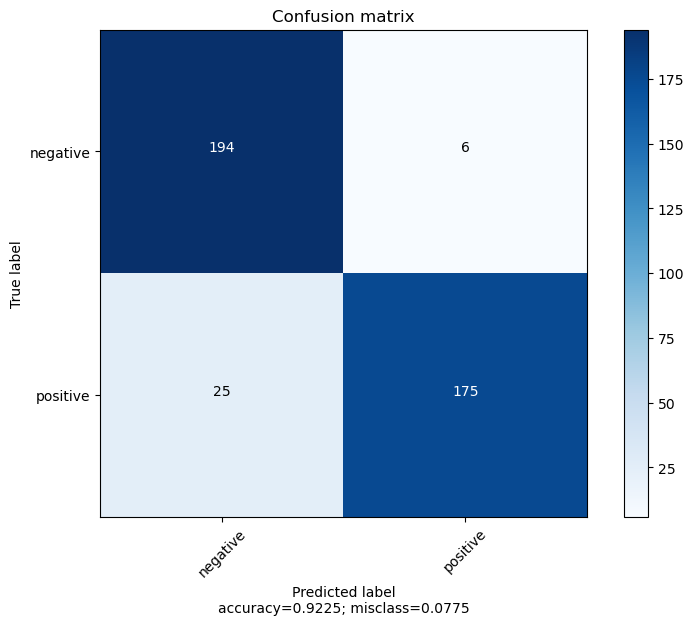

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
predictions = rf.predict(test_x)
cm = confusion_matrix(test_y, predictions, labels=rf.classes_)
plot_confusion_matrix(cm,['negative','positive'])

In [46]:
## saliency map

In [53]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms

In [54]:
no_rgb_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.ToPILImage()
])

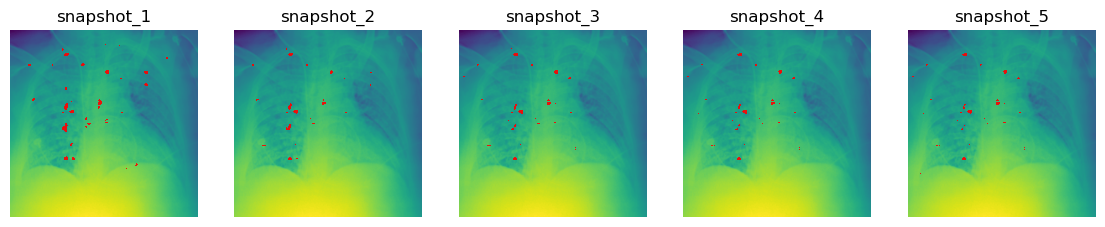

In [64]:
img_path = './test/070c921f-171c-420c-915b-e49e3f600c38.png'#path of a image to show saliency map
image = Image.open(img_path).convert('RGB')
processed_image = no_rgb_preprocess(Image.open(img_path))
X = preprocess(image)
X = X.to(device)
X = X.view(-1,3,224,224)
X.requires_grad_()
fig,ax = plt.subplots(1,5,figsize=(14,8))
idx = 1
for root, dirs, files in os.walk(snapshots_dir, topdown=False):
    for file_name in sorted(files):
        file_path = os.path.join(root, file_name)
        checkpoint = torch.load(file_path)
        densenet_based.load_state_dict(checkpoint['model_state_dict'])
        densenet_based.eval()
        score_max = torch.special.expit(densenet_based(X))
        score_max.backward()
        saliency, _ = torch.max(X.grad.data.abs(),dim=1)
        model_name = 'snapshot_'+str(idx)
        ax[idx-1].imshow(processed_image)
        cmap2 = matplotlib.colors.ListedColormap(['none', 'red'])
        ax[idx-1].imshow(saliency[0].cpu(),cmap=cmap2, alpha=.9)
        ax[idx-1].set_title(model_name)
        ax[idx-1].axis('off')
        idx += 1